In [3]:
import pickle

import gymnasium as gym
import numpy as np
from helper import initialize_grids, initialize_q_table, initialize_state_dict, initialize_random_start, \
    epsilon_greedy_policy, get_closest_in_grid, plot_rewards, plot_steps, evaluate
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches


def train(q, rand_init=True):
    # Initialize variables to track rewards
    reward_list = []
    avg_reward_list = []
    total_steps = []
    file = open('trace/trace_train.txt', 'w')

    for episode in range(n_training_episodes):
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        state = env.reset()
        if rand_init:
            state = initialize_random_start(grid_x, grid_v)
        steps = 0
        tot_reward, reward = 0, 0
        terminated = False

        for step in range(max_steps):
            # Choose the action At using epsilon greedy policy
            action = epsilon_greedy_policy(q, state, epsilon, grid_x, grid_v, state_to_qtable, env)

            file.write(f'{state[0]},{state[1]},{action}\n')

            new_state, reward, terminated, truncated, info = env.step(action)

            s = state_to_qtable[get_closest_in_grid(state, grid_x, grid_v)]
            ns = state_to_qtable[get_closest_in_grid(new_state, grid_x, grid_v)]

            # Calculate current learning rate
            lr = max(min_lr, initial_lr * np.exp(-k * episode))

            # Update Q table
            q[s][action] = q[s][action] + lr * (reward + gamma * np.max(q[ns]) - q[s][action])

            steps += 1

            # If done, finish the episode
            if terminated:  # or truncated:
                total_steps.append(steps)
                break

            # Our state is the new state
            state = new_state

            # Update total reward
            tot_reward += reward

            # Track rewards
            reward_list.append(tot_reward)

        if (episode + 1) % 10 == 0:
            avg_reward = np.mean(reward_list)
            avg_reward_list.append(avg_reward)
            reward_list = []
            print(f"episode: {episode}\t average reward: {avg_reward}\t avg steps: {np.mean(total_steps[-10:])}"
                  f"\t lr: {lr}\t epsilon: {epsilon}")

    return q, avg_reward_list, total_steps

In [11]:
env = gym.make("MountainCar-v0")

# initialize size of state and action space
state_space = 20 * 20
action_space = env.action_space.n

observation, info = env.reset(seed=42)

# Training parameters
n_training_episodes = 5000  # Total training episodes
initial_lr = 0.2  # Learning rate       # old: 1
k = 0.005  # lr decay                    # old: 0.005
min_lr = 0.005


# Environment parameters
max_steps = 10000  # Max steps per episode
gamma = 0.99  # Discounting rate
eval_seed = []  # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1#0.95   # Exploration probability at start                     # old: 1
min_epsilon = 0.05  # Minimum exploration probability
decay_rate = 0.01  # Exponential decay rate for exploration prob           # old: 0.002


grid_x, grid_v = initialize_grids()
state_to_qtable = initialize_state_dict()

# Training
q_car = initialize_q_table(state_space, action_space)
q_car, avg_rewards, total_steps = train(q_car)


#
# Plot V values for random init training
actions = np.max(q_car, axis=1)
actions = actions.reshape((20, 20))
plt.figure(figsize=(16, 12))
ax = plt.subplot(111)
ax = sns.heatmap(actions, annot=True)
plt.ylim(0, 20)
plt.xlabel("Position", fontsize=20)
plt.ylabel("Velocity", fontsize=20)
plt.title("Q values for optimal action - random init w/ lr decay", fontdict={'fontsize': 25})
# plt.savefig('plots/v_values_rand_decay')
with open('plots/q_values.pkl','wb') as fid:
    pickle.dump(ax, fid)
plt.savefig('plots/q_values_rand_decay.png')
plt.close()

plot_steps(total_steps, 'rand_decay')
plot_rewards(avg_rewards, 'rand_decay')

# # Save Q table
np.savetxt('data/q_rand_decay.txt', q_car)
np.array(avg_rewards)
np.savetxt('data/avg_rewards_rand_decay.txt', avg_rewards)
np.array(total_steps)
np.savetxt('data/total_steps_rand_decay.txt', total_steps)

env.close()

episode: 9	 average reward: -4517.1130121801725	 avg steps: 4171.5	 lr: 0.19119949636662	 epsilon: 0.9182346260076668
episode: 19	 average reward: -2343.918956637315	 avg steps: 3010.5	 lr: 0.1818745868936463	 epsilon: 0.8356111772461942
episode: 29	 average reward: -787.7177692807156	 avg steps: 1387.1	 lr: 0.17300445862214828	 epsilon: 0.760850389199637
episode: 39	 average reward: -1197.462803179564	 avg steps: 1472.9	 lr: 0.1645669316112037	 epsilon: 0.6932040307732564
episode: 49	 average reward: -570.3968795205622	 avg steps: 968.8	 lr: 0.15654090764837364	 epsilon: 0.6319950744751953
episode: 59	 average reward: -521.9560201050948	 avg steps: 876.4	 lr: 0.1489063174931819	 epsilon: 0.5766109204977817
episode: 69	 average reward: -353.3511923688394	 avg steps: 630.0	 lr: 0.14164407069356	 epsilon: 0.5264972656127527
episode: 79	 average reward: -315.1616005495449	 avg steps: 583.3	 lr: 0.13473600784977355	 epsilon: 0.481152555518238
episode: 89	 average reward: -249.9315988250105

episode: 679	 average reward: -81.87037037037037	 avg steps: 163.0	 lr: 0.006708110834429727	 epsilon: 0.0510687203354661
episode: 689	 average reward: -81.22291407222914	 avg steps: 161.6	 lr: 0.006380952408521593	 epsilon: 0.05096701814894567
episode: 699	 average reward: -83.77480219111382	 avg steps: 165.3	 lr: 0.006069749687324441	 epsilon: 0.05087499420508591
episode: 709	 average reward: -82.0203578038248	 avg steps: 163.1	 lr: 0.005773724501937017	 epsilon: 0.05079172749732636
episode: 719	 average reward: -81.61728395061728	 avg steps: 163.0	 lr: 0.005492136635203219	 epsilon: 0.05071638466446886
episode: 729	 average reward: -91.50198976691301	 avg steps: 176.9	 lr: 0.005224281970783647	 epsilon: 0.05064821165011856
episode: 739	 average reward: -83.00182704019488	 avg steps: 165.2	 lr: 0.005	 epsilon: 0.05058652615583411
episode: 749	 average reward: -83.21367521367522	 avg steps: 164.8	 lr: 0.005	 epsilon: 0.05053071081245549
episode: 759	 average reward: -84.39180229053646

episode: 1429	 average reward: -113.45636687444346	 avg steps: 225.6	 lr: 0.005	 epsilon: 0.050000591092513605
episode: 1439	 average reward: -113.88141592920354	 avg steps: 227.0	 lr: 0.005	 epsilon: 0.05000053484262383
episode: 1449	 average reward: -119.62521222410867	 avg steps: 236.6	 lr: 0.005	 epsilon: 0.050000483945618804
episode: 1459	 average reward: -118.78107764106916	 avg steps: 236.7	 lr: 0.005	 epsilon: 0.05000043789210419
episode: 1469	 average reward: -118.67713194739075	 avg steps: 236.7	 lr: 0.005	 epsilon: 0.05000039622116093
episode: 1479	 average reward: -114.47138350608382	 avg steps: 222.9	 lr: 0.005	 epsilon: 0.05000035851573223
episode: 1489	 average reward: -112.52986079928155	 avg steps: 223.7	 lr: 0.005	 epsilon: 0.05000032439844948
episode: 1499	 average reward: -115.86470078057242	 avg steps: 231.6	 lr: 0.005	 epsilon: 0.05000029352785544
episode: 1509	 average reward: -113.69707705934455	 avg steps: 226.8	 lr: 0.005	 epsilon: 0.05000026559498684
episode:

episode: 2179	 average reward: -122.70704845814979	 avg steps: 228.0	 lr: 0.005	 epsilon: 0.05000000032692403
episode: 2189	 average reward: -110.51392281387396	 avg steps: 205.7	 lr: 0.005	 epsilon: 0.0500000002958131
episode: 2199	 average reward: -99.66776496430532	 avg steps: 183.1	 lr: 0.005	 epsilon: 0.05000000026766276
episode: 2209	 average reward: -92.73742399115534	 avg steps: 181.9	 lr: 0.005	 epsilon: 0.050000000242191284
episode: 2219	 average reward: -95.60010706638116	 avg steps: 187.8	 lr: 0.005	 epsilon: 0.050000000219143734
episode: 2229	 average reward: -126.4221635883905	 avg steps: 228.4	 lr: 0.005	 epsilon: 0.05000000019828945
episode: 2239	 average reward: -98.93249607535321	 avg steps: 192.1	 lr: 0.005	 epsilon: 0.05000000017941972
episode: 2249	 average reward: -193.17757009345794	 avg steps: 311.3	 lr: 0.005	 epsilon: 0.050000000162345674
episode: 2259	 average reward: -113.15130023640661	 avg steps: 212.5	 lr: 0.005	 epsilon: 0.05000000014689644
episode: 2269

episode: 2929	 average reward: -89.54623779437105	 avg steps: 175.1	 lr: 0.005	 epsilon: 0.050000000000180816
episode: 2939	 average reward: -106.15907953976989	 avg steps: 200.9	 lr: 0.005	 epsilon: 0.050000000000163615
episode: 2949	 average reward: -117.13966725043782	 avg steps: 229.4	 lr: 0.005	 epsilon: 0.050000000000148044
episode: 2959	 average reward: -116.33558254610887	 avg steps: 223.3	 lr: 0.005	 epsilon: 0.05000000000013396
episode: 2969	 average reward: -109.39419291338582	 avg steps: 204.2	 lr: 0.005	 epsilon: 0.050000000000121204
episode: 2979	 average reward: -121.66597767672592	 avg steps: 242.9	 lr: 0.005	 epsilon: 0.05000000000010967
episode: 2989	 average reward: -116.35466900482244	 avg steps: 229.1	 lr: 0.005	 epsilon: 0.050000000000099236
episode: 2999	 average reward: -111.38361266294227	 avg steps: 215.8	 lr: 0.005	 epsilon: 0.05000000000008979
episode: 3009	 average reward: -109.24883504193849	 avg steps: 215.6	 lr: 0.005	 epsilon: 0.05000000000008125
episod

episode: 3679	 average reward: -110.9856215213358	 avg steps: 216.6	 lr: 0.005	 epsilon: 0.0500000000000001
episode: 3689	 average reward: -105.025	 avg steps: 205.0	 lr: 0.005	 epsilon: 0.05000000000000009
episode: 3699	 average reward: -90.84584755403868	 avg steps: 176.8	 lr: 0.005	 epsilon: 0.050000000000000086
episode: 3709	 average reward: -98.5308056872038	 avg steps: 190.9	 lr: 0.005	 epsilon: 0.05000000000000008
episode: 3719	 average reward: -95.82088744588745	 avg steps: 185.8	 lr: 0.005	 epsilon: 0.05000000000000007
episode: 3729	 average reward: -113.17052154195011	 avg steps: 221.5	 lr: 0.005	 epsilon: 0.050000000000000065
episode: 3739	 average reward: -105.0166163141994	 avg steps: 199.6	 lr: 0.005	 epsilon: 0.05000000000000006
episode: 3749	 average reward: -85.54928741092637	 avg steps: 169.4	 lr: 0.005	 epsilon: 0.05000000000000005
episode: 3759	 average reward: -97.60720130932897	 avg steps: 184.3	 lr: 0.005	 epsilon: 0.050000000000000044
episode: 3769	 average rewa

episode: 4499	 average reward: -83.15455100794135	 avg steps: 164.7	 lr: 0.005	 epsilon: 0.05
episode: 4509	 average reward: -80.23139974779319	 avg steps: 159.6	 lr: 0.005	 epsilon: 0.05
episode: 4519	 average reward: -84.40720720720721	 avg steps: 167.5	 lr: 0.005	 epsilon: 0.05
episode: 4529	 average reward: -78.77493606138107	 avg steps: 157.4	 lr: 0.005	 epsilon: 0.05
episode: 4539	 average reward: -90.45650938032973	 avg steps: 176.9	 lr: 0.005	 epsilon: 0.05
episode: 4549	 average reward: -88.85514834205934	 avg steps: 172.9	 lr: 0.005	 epsilon: 0.05
episode: 4559	 average reward: -84.2748643761302	 avg steps: 166.9	 lr: 0.005	 epsilon: 0.05
episode: 4569	 average reward: -80.74528301886792	 avg steps: 160.0	 lr: 0.005	 epsilon: 0.05
episode: 4579	 average reward: -85.39595719381688	 avg steps: 169.2	 lr: 0.005	 epsilon: 0.05
episode: 4589	 average reward: -80.10056568196103	 avg steps: 160.1	 lr: 0.005	 epsilon: 0.05
episode: 4599	 average reward: -77.60739779364049	 avg steps:

In [12]:
from helper import greedy_policy, initialize_grids, initialize_state_dict, get_closest_in_grid
import matplotlib.image as img


# Evaluation Parameters
seed = []
n_eval_episodes = 1
max_steps = 10000

# load q table
q = np.loadtxt('data/q_rand_decay.txt')

# initialize discretization
grid_x, grid_v = initialize_grids()
state_to_qtable = initialize_state_dict()

# trace
file = open('trace/trace_eval.txt', 'w')

env = gym.make('MountainCar-v0')

for episode in range(n_eval_episodes):
    if seed:
        state = env.reset(seed=seed[episode])
    else:
        state = env.reset()[0]
    step = 0
    terminated = False
    total_rewards_ep = 0

    for step in range(max_steps):
        action = greedy_policy(q, state, grid_x, grid_v, state_to_qtable)

        # write current state and action taken to trace
        file.write(f'{state[0]},{state[1]},{action}\n')

        new_state, reward, terminated, truncated, info = env.step(action)
        total_rewards_ep += reward

        if terminated:  # or truncated:
            break
        state = new_state


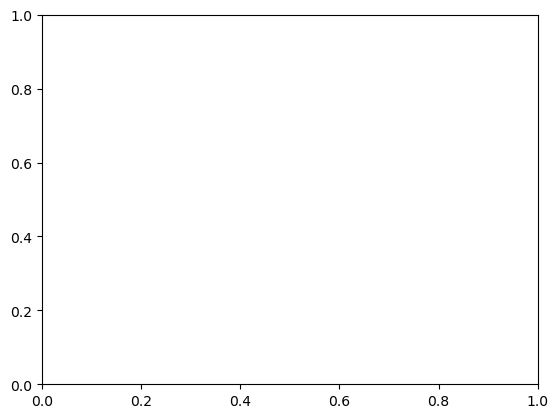

In [13]:
trace = []
actions = []

# load trace and actions into list
with open('trace/trace_eval.txt') as f:
    for line in f.readlines():
        x, v, a = line.split(',')
        trace.append((float(x), float(v)))
        actions.append(int(a))

# discretize trace
trace_discrete = []
grid_x, grid_v = initialize_grids()
state_to_q = initialize_state_dict()
for trac in trace:
    # state = state_to_q[get_closest_in_grid(np.asarray(trac), grid_x, grid_v)]
    x, v = get_closest_in_grid(np.asarray(trac), grid_x, grid_v)
    state = [grid_x.index(x)+0.5, grid_v.index(v)+0.5]
    trace_discrete.append(state)

# load v values plot
plot = img.imread('plots/q_values_rand_decay.png')

# plot trace onto plot
fig, ax = plt.subplots()
# ax.imshow(plot, extent=[0, 20, 0, 20])
with open('plots/q_values.pkl', 'rb') as fid:
    ax = pickle.load(fid)
ax.plot(*zip(*trace_discrete[::1]))

# plot starting point
sns.lineplot(x=[trace_discrete[0][0]], y=[trace_discrete[0][1]], marker='o', markersize=25, markeredgecolor='green', color='green', markeredgewidth=2)
# plot finish point
sns.lineplot(x=[trace_discrete[-1][0]+1], y=[trace_discrete[-1][1]], marker='o', markersize=25, markeredgecolor='red', color='red', markeredgewidth=2)

ax.set_xticklabels(grid_x)
ax.set_yticklabels(grid_v)
plt.savefig('trace/trace.png')
plt.close()
